# Dimensionality reduction on trial features

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.utils import resample

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [3]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
# states_file = pd.read_parquet(data_path+'states_trial_type_5k_5_09-24-2025')
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')


In [ ]:
## Get sequences per trial epoch
# results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
# filename = str(results_path + 'epoch_sequences_10_03-11-2025')
filename = str(data_path + 'all_sequences_5k_09-24-2025')
filename = str(data_path + 'all_sequences_09-29-2025')
all_sequences = pd.read_parquet(filename)
# all_sequences = pickle.load(open(filename, 'rb'))

design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]
df = design_df.copy()
df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
df['side'] = df['choice'].copy()
df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'

df['session'] = df['sample'].str.split().str[:1].str.join('')
df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')
## Get timing data


# Get timing info
vars = ['trial_id', 'session', 'mouse_name']

elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)

# Merge

merged_df = df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])

merged_df['contrast'] = merged_df['contrast'].astype(float)
merged_df['block'] = merged_df['block'].astype(float)

# Timing quantiles and choice
merged_df['response_qt'] = pd.qcut(merged_df['response'], 4, labels=False)/4
merged_df['elongation_qt'] = pd.qcut(merged_df['elongation'], 4, labels=False)/4

merged_df['choice'] = merged_df['trial_type'].str.split().str[3:4].str.join('')
merged_df.loc[merged_df['choice']=='left', 'choice'] = 0
merged_df.loc[merged_df['choice']=='right', 'choice'] = 1

merged_df.loc[merged_df['feedback']=='correct', 'feedback'] = 1
merged_df.loc[merged_df['feedback']=='incorrect', 'feedback'] = 0
del states_file

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/fig1_segmentation/all_sequences_09-29-2025'

## Get sequences per trial

In [ ]:
all_sequences['session'] = all_sequences['sample'].str[:36]

In [ ]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

## Separate states per variable (one-hot encoding)

In [ ]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

In [ ]:
final_matrix = binarized.copy()

In [9]:
plt.figure(figsize=(10, 4))
plt.imshow(np.array(final_matrix), aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

([<matplotlib.axis.XTick at 0x76f1b7b1b370>,
 [Text(0, 0, '0'),
  Text(160, 0, '160'),
  Text(320, 0, '320'),
  Text(480, 0, '480'),
  Text(640, 0, '640'),
  Text(800, 0, '800'),
  Text(960, 0, '960'),
  Text(1120, 0, '1120')])

# PCA

In [ ]:
n_components = 500
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
standardized_X = scaler.fit_transform(final_matrix)
X_pca = pca.fit_transform(standardized_X)
# X_pca = pca.fit_transform(final_matrix)

Text(0.5, 1.0, 'Explained Variance by PCA')

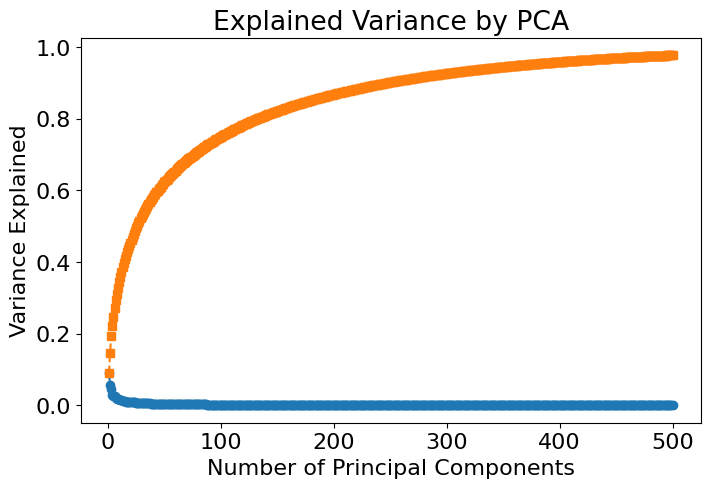

In [ ]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

# UMAP

In [ ]:
ori_X = X_pca.copy()
# ori_X = final_matrix.copy()

In [ ]:
reducer = umap.UMAP(random_state= 42, n_components=2)
# reducer = umap.UMAP(n_components=2)

embedding = reducer.fit_transform(ori_X)
# embedding = reducer.fit_transform(X_pca)
embedding.shape

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(133815, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, "['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']")

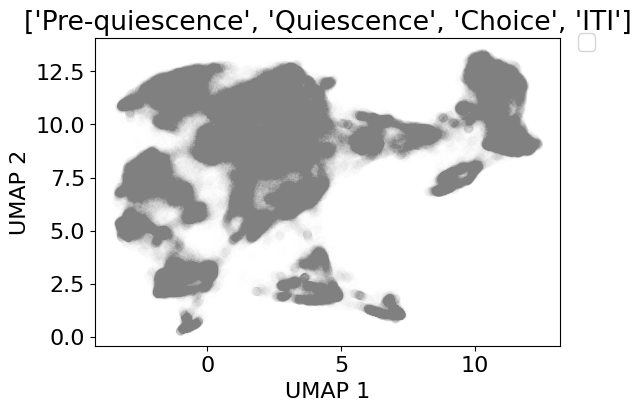

In [ ]:
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 16})

scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.002,
    c='grey'  # Choose a colormap
)   
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title(epoch_to_analyse)

# Save the figure as an SVG file
# plt.savefig(file_path+'UMAP_grey', format="svg")

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

57


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

8


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

9


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_10212/3757032376.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1319, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/opt/anaconda3/envs/iblenv/lib/p

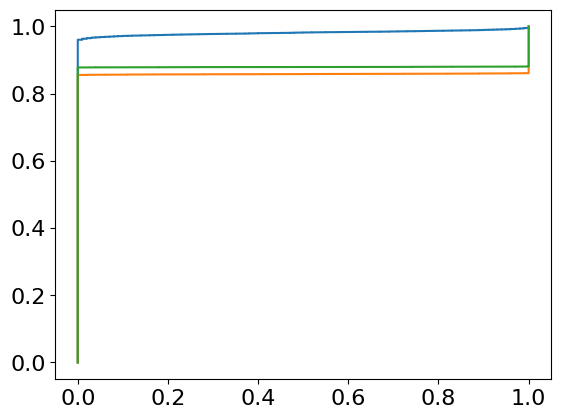

In [ ]:
repeats = 100

# K = [3, 4, 5, 6, 7, 8, 9, 10, 13, 16]
K = [3, 4, 5, 6, 7, 8, 9, 10]
K = [3, 4, 5, 6, 7, 8, 9, 10, 11]
K = [4, 5, 6, 7, 8, 9, 10, 11]
K = [5, 7, 8, 9]
data_2d = embedding


# Subsample data once
original_indices = np.arange(0, np.shape(data_2d)[0], 1)
n_samples = 10000  # computationally tractable
new_indices = resample(original_indices, n_samples=n_samples, replace=False)

new_data = data_2d[new_indices, :]

for i, k in enumerate(K):

    consensus_matrix = np.zeros((n_samples, n_samples))

    for r in range(repeats):
        # CLUSTER
        kmeans_trials = KMeans(n_clusters=k)
        kmeans_trials.fit(data_2d)
        clusters = kmeans_trials.predict(new_data)

        for i in range(n_samples):
            for j in range(i, n_samples):
                if clusters[i] == clusters[j]:
                    consensus_matrix[i, j] += 1
                    if i != j:
                        consensus_matrix[j, i] += 1  # symmetry
                            
    # Normalize to [0, 1]
    consensus_matrix /= repeats

    print(k)
    
    e = ECDF(np.ravel(consensus_matrix))
    low_index = np.where(e.x>.1)[0][0]
    high_index = np.where(e.x<0.9)[0][-1]
    PAC = e.y[high_index] - e.y[low_index]
    plt.step(e.x[::10], e.y[::10], label=str(str(k)+' '+str(PAC))) # color=palette[i],
    # plt.step(e.x, e.y, label=str(str(k)+' '+str(np.round(PAC, 3)))) # color=palette[i],
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.show()


In [202]:
optimal_k = 9

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


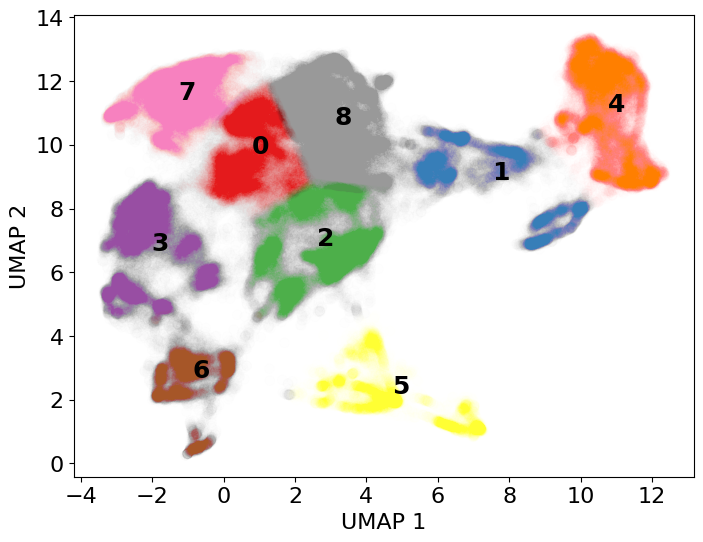

In [203]:
# Step 2: Perform KMeans Clustering
data_2d = embedding
# data_2d = ori_X
# data_2d = final_matrix

kmeans_trials = KMeans(n_clusters=optimal_k, random_state=2025)
kmeans_trials.fit(data_2d)

y_kmeans_trials = kmeans_trials.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# import hdbscan

# # HDBSCAN
# hdb = hdbscan.HDBSCAN(min_cluster_size=10)
# y_kmeans_trials = hdb.fit_predict(data_2d)

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))
# Plot each cluster with a different color
palette = sns.color_palette("dark:salmon_r", len(np.unique(y_kmeans_trials)), as_cmap=False)
palette = sns.color_palette("Set1", len(np.unique(y_kmeans_trials)), as_cmap=False)
# Map the cluster labels to colors
colors = [palette[i] for i in y_kmeans_trials]
data_2d = embedding
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], s=50, alpha=0.005, c=colors) # sns.color_palette("Set2", as_cmap=True) , cmap='Set2' c=y_kmeans_trials, 

# Plot the centroids
centroids = kmeans_trials.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=1, fontsize=18, weight='bold')

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.title(epoch_to_analyse)

# Save the figure as an SVG file
save_path = '/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE/'
# plt.savefig(save_path+'trial_clusters_umap.svg', format="svg")
plt.show()

In [191]:
design_df['trial_cluster'] = y_kmeans_trials

In [192]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
# np.save(data_path+'10_trial_cluster', design_df)
design_df.to_parquet(data_path+'9_cluster_per_trial',compression='gzip') 

In [193]:
merged_df = merged_df[['sample', 'trial_type', 'mouse_name', 'Choice', 'ITI', 'Pre-quiescence',
       'Quiescence', 'feedback', 'choice', 'block', 'contrast', 'side',
       'session', 'trial_id', 'elongation', 'response', 'reaction',
       'response_qt', 'elongation_qt']]

In [194]:
merged_df.keys()

Index(['sample', 'trial_type', 'mouse_name', 'Choice', 'ITI', 'Pre-quiescence',
       'Quiescence', 'feedback', 'choice', 'block', 'contrast', 'side',
       'session', 'trial_id', 'elongation', 'response', 'reaction',
       'response_qt', 'elongation_qt'],
      dtype='object')

In [195]:
merged_df = merged_df.merge(design_df[['sample', 'mouse_name', 'session', 'trial_cluster']], on=['sample', 'mouse_name', 'session'])

(array([16403., 10855., 18908., 17240.,     0., 18202.,  7943.,  9838.,
        13108., 21318.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

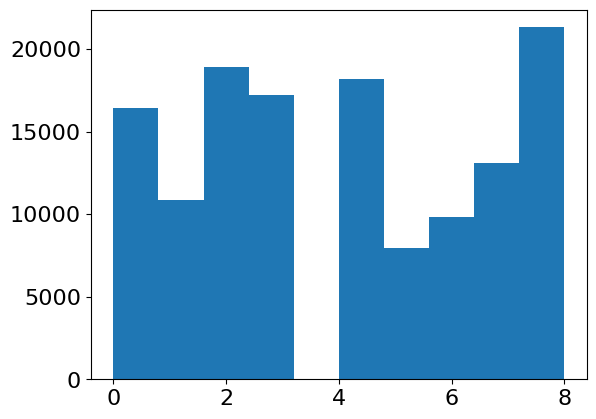

In [196]:
plt.hist(y_kmeans_trials)

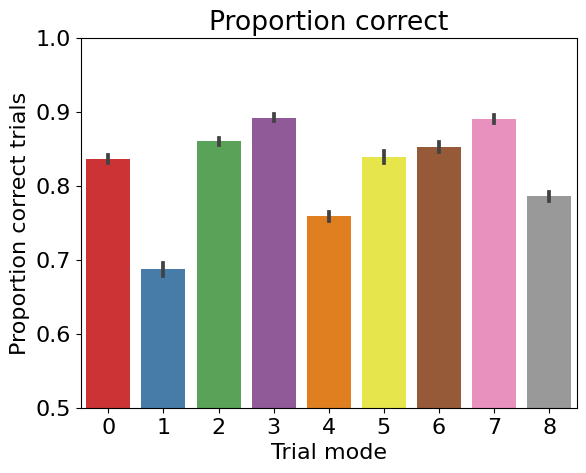

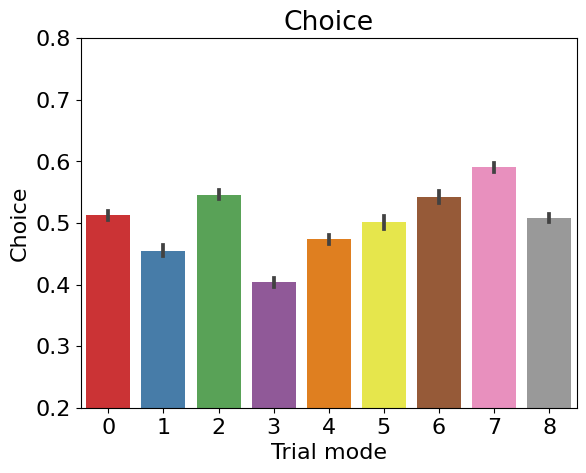

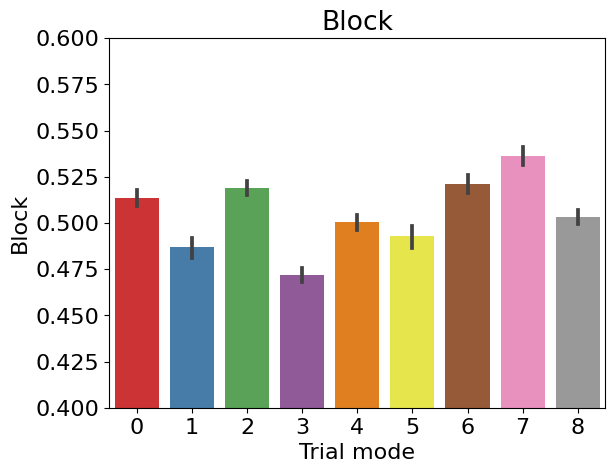

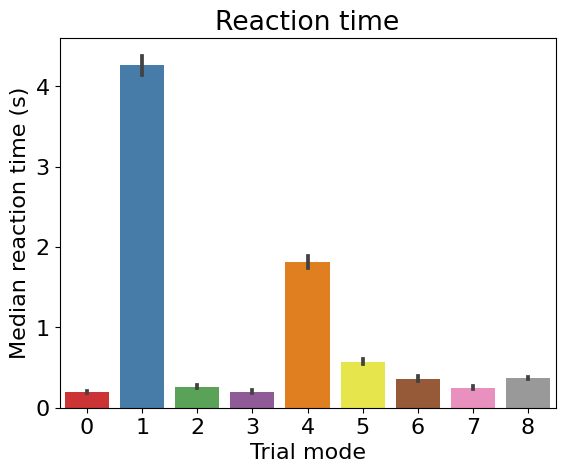

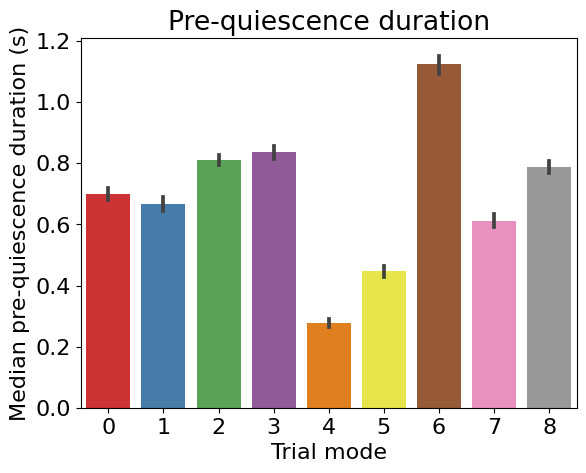

In [204]:
# save_path = prefix + 'representation_learning_variability/Exported figures/COSYNE/'
plt.rcParams.update({'font.size': 16})

palette = sns.color_palette("dark:salmon_r", 7, as_cmap=False)
palette = sns.color_palette("Set1", 10, as_cmap=False)
sns.barplot(x='trial_cluster', y='feedback', data=merged_df, palette=palette)
plt.title('Proportion correct')
plt.ylabel('Proportion correct trials')
plt.ylim([0.5,1])
plt.xlabel('Trial mode')
plt.show()

sns.barplot(x='trial_cluster', y='choice', data=merged_df, palette=palette)
plt.ylabel('Choice')
plt.title('Choice')
plt.ylim([0.2,.8])

plt.xlabel('Trial mode')
plt.show()

sns.barplot(x='trial_cluster', y='block', data=merged_df, palette=palette)
plt.ylabel('Block')
plt.title('Block')
plt.ylim([0.4,.6])

plt.xlabel('Trial mode')
plt.show()


sns.barplot(x='trial_cluster', y='reaction', data=merged_df, palette=palette)
plt.ylabel('Median reaction time (s)')
plt.title('Reaction time')
plt.xlabel('Trial mode')
plt.show()

sns.barplot(x='trial_cluster', y='elongation', data=merged_df, palette=palette)
plt.ylabel('Median pre-quiescence duration (s)')
plt.title('Pre-quiescence duration')
plt.xlabel('Trial mode')
plt.show()


# sns.barplot(x='trial_cluster', y='feedback', hue='choice', data=merged_df, palette=palette)
# plt.title('Proportion correct')
# plt.ylabel('Proportion correct trials')
# plt.ylim([0.5,1])
# plt.xlabel('Trial mode')
# plt.show()

# sns.barplot(x='trial_cluster', y='reaction', hue='choice', data=merged_df, palette=palette)
# plt.ylabel('Median reaction time (s)')
# plt.title('Reaction time')
# plt.xlabel('Trial mode')
# plt.show()

# sns.barplot(x='trial_cluster', y='elongation', hue='choice', data=merged_df, palette=palette)
# plt.ylabel('Median pre-quiescence duration (s)')
# plt.title('Pre-quiescence duration')
# plt.xlabel('Trial mode')
# plt.show()

# sns.barplot(x='trial_cluster', y='reaction', hue='prev_feedback', data=merged_df)
# plt.ylabel('Median reaction time (s)')
# plt.title('Reaction time')
# plt.xlabel('Trial mode')
# plt.show()

# sns.barplot(x='trial_cluster', y='elongation', hue='prev_feedback', data=merged_df)
# plt.ylabel('Median pre-quiescence duration (s)')
# plt.title('Pre-quiescence duration')
# plt.xlabel('Trial mode')
# plt.show()


# sns.barplot(x='cluster', y='choice', data=trial_clusters, palette=palette)
# plt.savefig(save_path+'trial_cluster_choice.svg', format="svg")
# plt.show()
# sns.barplot(x='cluster', y='block', data=trial_clusters, palette=palette)
# plt.savefig(save_path+'trial_cluster_block.svg', format="svg")
# plt.show()
# sns.barplot(x='cluster', y='contrast', data=trial_clusters, palette=palette)
# plt.savefig(save_path+'trial_cluster_contrast.svg', format="svg")
# plt.show()

# sns.barplot(x='cluster', y='prev_feedback', data=merged_df, palette=palette)
# plt.ylabel('Previous trial accuracy')
# plt.xlabel('Trial mode')

In [ ]:
# data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
# merged_df.to_parquet(data_path+'trial_clusters_5', compression='gzip')